In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model, load_model
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.utils import plot_model
from scipy.spatial import distance
from scipy.spatial.distance import cdist, cosine
import matplotlib.pyplot as plt
from tensorboard.plugins import projector
import joblib
import shap


2023-02-23 09:34:26.711008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 09:34:26.895537: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-23 09:34:27.829418: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-23 09:34:27.829601: W tensorfl

In [2]:
df = pd.read_csv('final_data/fifa_cleaned_all_columns.csv').drop(['Unnamed: 0'], axis=1)
df

,sofifa_id,short_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,...,body_Stocky,body_Unique,right_foot,left_foot,injury_risk,teamwork,passing_traits,attacking_traits,dribbling_traits,defending_traits
0,158023,L. Messi,CF,93,95,100500000.0,550000.0,27,169,67,...,0,0,3,5,0,1,0,1,1,0
1,20801,Cristiano Ronaldo,"LW, LM",92,92,79000000.0,375000.0,29,185,80,...,0,0,5,4,0,0,0,1,1,0
2,9014,A. Robben,"RM, LM, RW",90,90,54500000.0,275000.0,30,180,80,...,0,0,2,5,1,-1,0,2,1,0
3,41236,Z. Ibrahimović,ST,90,90,52500000.0,275000.0,32,195,95,...,0,0,5,4,0,1,0,1,1,0
4,41,Iniesta,"CM, LW",89,89,36000000.0,250000.0,30,170,65,...,0,0,5,4,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126283,261962,Song Defu,CDM,47,52,70000.0,1000.0,22,180,64,...,0,0,5,3,0,0,0,0,0,0
126284,262040,C. Porter,CM,47,59,110000.0,500.0,19,175,70,...,0,0,5,3,0,0,0,0,0,0
126285,262760,N. Logue,CM,47,55,100000.0,500.0,21,178,72,...,0,0,5,3,0,0,0,0,0,0
126286,262820,L. Rudden,ST,47,60,110000.0,500.0,19,173,66,...,0,0,5,3,0,0,0,0,0,0


In [3]:
columns = ['overall', 'potential', 
           #'age', 'height_cm', 'weight_kg', 'league_level', 
           'height_cm', 'weight_kg',
           'skill_moves', #'international_reputation', 
           'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 
           'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 
           'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 
           'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 
           'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 
           'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 
           'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 
           'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 
           'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 
           'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 
           #### Traits
           'One Club Player', 'Avoids Using Weaker Foot', 'Playmaker', 'Dives Into Tackles', 'Finesse Shot', 
           'Power Free-Kick', 'Leadership', 'Power Header', 'Technical Dribbler', 'Early Crosser', 'Takes Finesse Free Kicks', 
           'Through Ball', 'Giant Throw-in', 'Beat Offside Trap', 'Outside Foot Shot', 'Long Passer', 'Set Play Specialist', 'Chip Shot', 
           'Diver', 'Team Player', 'Injury Free', 'Injury Prone', 'Swerve Pass', 'Solid Player', 'Selfish', 'Speed Dribbler', 'Flair', 
           'Long Shot Taker', 'Long Throw-in', 'Backs Into Player', 'Target Forward', 
           #### Tags (Remove)
           #'Speedster', 'Complete Defender', 'Dribbler', 
           #'Tackling', 'Acrobat', 'Poacher', 'Crosser', 'FK Specialist', 'Complete Forward', 'Complete Midfielder', 'Engine', 
           #'Clinical Finisher', 'Aerial Threat', 'Tactician', 'Distance Shooter', 'Strength', 
           
           #### Newly created
           'att_workrate', 'def_workrate', 'body_Lean', 'body_Normal', 'body_Stocky', 'body_Unique', 'right_foot', 'left_foot', 
           'injury_risk', 'teamwork', 'passing_traits', 'attacking_traits', 'dribbling_traits', 'defending_traits']

In [4]:
### Train test Split
X = df[columns].copy()
# Target
y = df['overall']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=42)

In [5]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
emb_dim = 20
input = tf.keras.layers.Input(shape=X_train.shape[1:])

encoder = tf.keras.layers.Dense(X_train.shape[1:][0], activation='relu')(input)
encoder = tf.keras.layers.Dense(100, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(75, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(50, activation='relu')(encoder)
embedding = tf.keras.layers.Dense(emb_dim, activation='relu',name='embedding')(encoder)

decoder = tf.keras.layers.Dense(50, activation='relu')(embedding)
decoder = tf.keras.layers.Dense(75, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(100, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(X_train.shape[1], activation='sigmoid')(decoder),

autoencoder = Model(input, decoder)
autoencoder.compile(loss='mae', optimizer='adam')
callback = EarlyStopping(monitor='loss', patience=3)
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.2, #shuffle=False, 
            callbacks=[callback], validation_data = (X_test, X_test))


2023-02-23 09:34:33.836200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-23 09:34:33.847795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-23 09:34:33.849624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-23 09:34:33.852542: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/100
3355/3355 [==============================] - 18s 3ms/step - loss: 0.0494 - val_loss: 0.0390
Epoch 2/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0373 - val_loss: 0.0361
Epoch 3/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0351 - val_loss: 0.0351
Epoch 4/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0338 - val_loss: 0.0332
Epoch 5/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0329 - val_loss: 0.0335
Epoch 6/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0322 - val_loss: 0.0327
Epoch 7/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0318 - val_loss: 0.0319
Epoch 8/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0313 - val_loss: 0.0312
Epoch 9/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0307 - val_loss: 0.0303
Epoch 10/100
3355/3355 [==============================] - 11s 3m

In [7]:
player_encoder = Model(input, embedding)
player_encoder.predict(scaler.transform(X))

3947/3947 [==============================] - 6s 1ms/step


array([[0.621976  , 2.278394  , 0.        , ..., 3.0132732 , 0.        ,
        3.6483605 ],
       [0.06086478, 3.0172832 , 0.        , ..., 3.1235812 , 0.        ,
        3.059931  ],
       [0.47297654, 3.2064846 , 0.        , ..., 2.273674  , 0.        ,
        3.3259    ],
       ...,
       [1.4583727 , 0.54720914, 0.        , ..., 0.7549296 , 0.        ,
        1.2715617 ],
       [1.079473  , 0.5915077 , 0.        , ..., 1.2331204 , 0.        ,
        0.49782106],
       [1.4383804 , 0.6239178 , 0.        , ..., 0.8069597 , 0.        ,
        1.2195349 ]], dtype=float32)

In [8]:
background = X_train[np.random.choice(X_train.shape[0], 800, replace=False)]
explainer = shap.DeepExplainer(player_encoder, background)
shap_values = explainer.shap_values(X_test)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


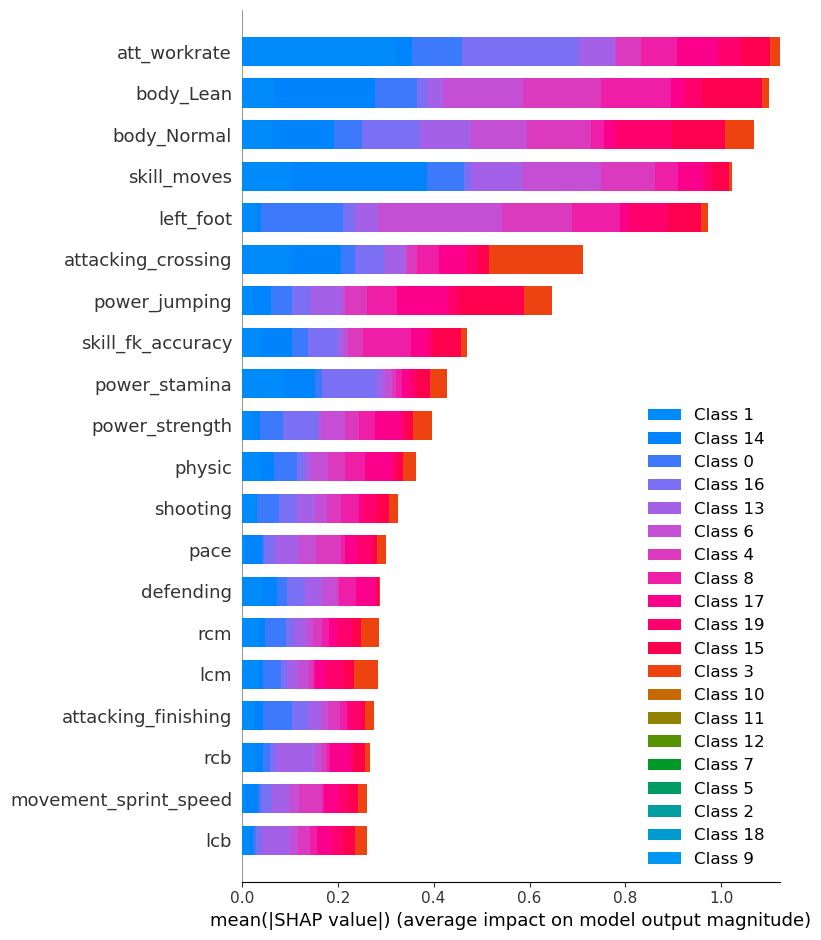

In [9]:
shap.summary_plot(shap_values, plot_type = 'bar', feature_names = df[columns].columns)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


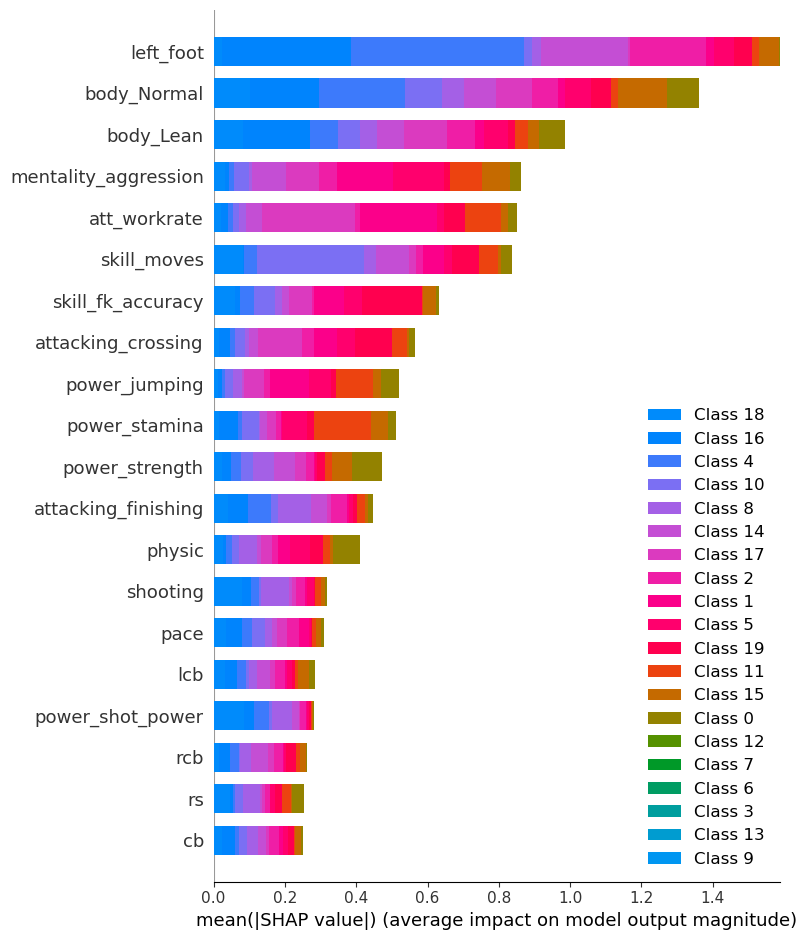

In [10]:
from tensorflow import keras
saved_encoder = keras.models.load_model('models/encoder/')

background = X_train[np.random.choice(X_train.shape[0], 800, replace=False)]
explainer = shap.DeepExplainer(saved_encoder, background)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, plot_type = 'bar', feature_names = df[columns].columns)

You have provided over 5k background samples! For better performance consider using smaller random sample.


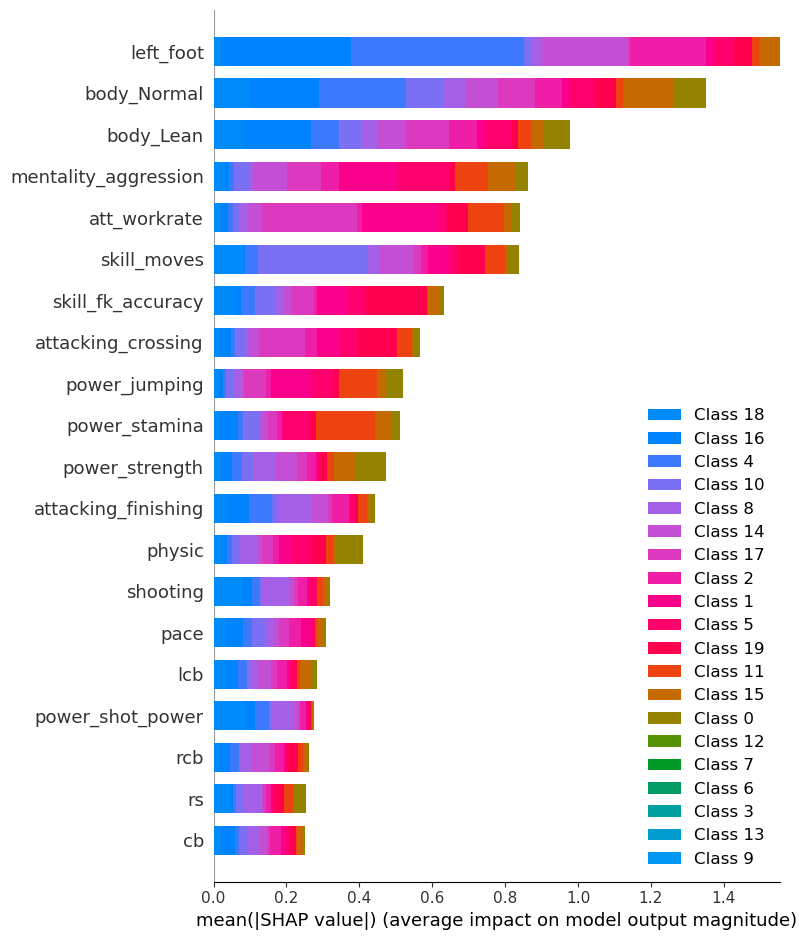

In [16]:
background = X_train[np.array(list(range(10000)))]
explainer = shap.DeepExplainer(saved_encoder, background)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, plot_type = 'bar', feature_names = df[columns].columns)